<a href="https://colab.research.google.com/github/Abderrahmane-Br/Hybrid-model-for-time-series-forecasting/blob/CNN-LSTM/LSTM_CNN(lstm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [748]:
elect_data = pd.read_csv("/content/BrentSpotPrice.csv", index_col="Date")
# elect_data = pd.read_csv("/content/Electric_Production.csv", index_col="DATE")
# elect_data = pd.read_csv("/content/MedicineData.csv", index_col="date")
# elect_data = pd.read_csv("/content/S&P500.csv", index_col="Date")
# elect_data = pd.read_csv("/content/YearlySunspots.csv", usecols=["time", "value"], index_col="time", parse_dates=True)
# elect_data = pd.read_csv("/content/covid_day_wise.csv", usecols=["Date", "New deaths"], index_col="Date")
# elect_data = pd.read_csv("/content/PDB_Load_History.csv", usecols=["date", "demand"], index_col="date")
# elect_data = pd.read_csv("/content/daily-total-female-births-CA.csv", index_col="date")
elect_data.index = pd.to_datetime(elect_data.index)


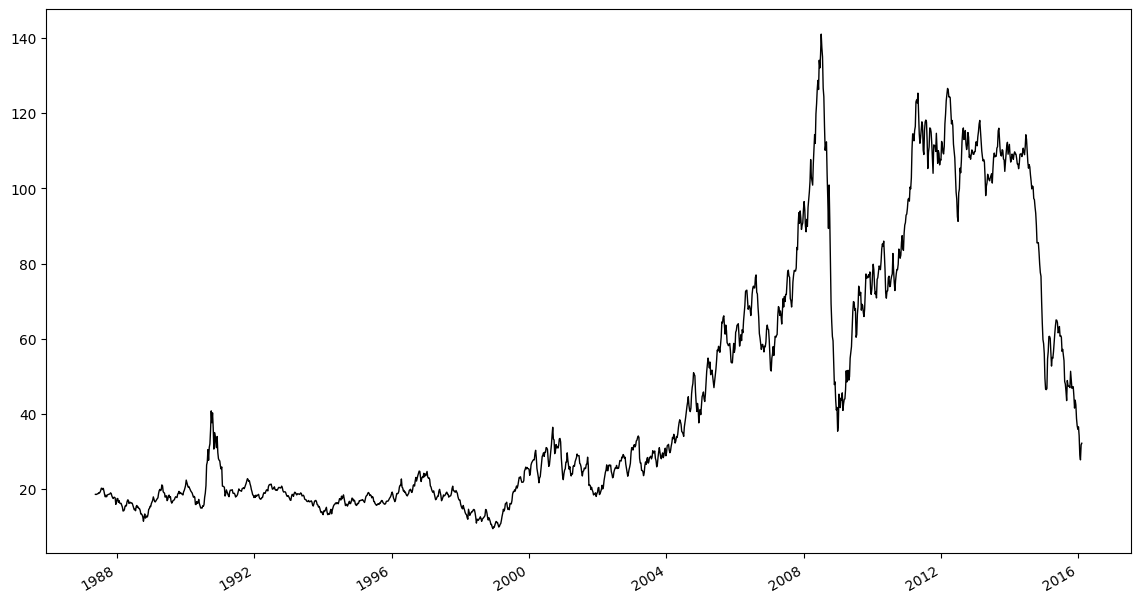

In [749]:
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = [14, 8]
loc = mdates.MonthLocator(4)
min_loc = mdates.MonthLocator()
fig, ax = plt.subplots()
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_minor_locator(min_loc)
ax.tick_params(colors="black")
plt.xticks(rotation=45)
fig.autofmt_xdate()

ax.plot(elect_data,'-', color="black", linewidth=1)
# plt.savefig('../test1.png', dpi=300)

In [750]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input):
        out, (hidden, cell) = self.lstm(input.view(len(input), 1))
        out = self.linear(out)
        return out

In [751]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(elect_data)
train_scaled = scaler.transform(elect_data)
split_point = int(len(train_scaled) * 0.7)
# inputs = torch.tensor(elect_data["Brent Spot Price"], dtype=torch.float32)
train_set = torch.tensor(train_scaled[:split_point], dtype=torch.float32)
test_set = torch.tensor(train_scaled[split_point:], dtype=torch.float32)

In [752]:
model = CNN_LSTM(1, 40, 2)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
loss_fun = nn.MSELoss()
epochs = 250

In [757]:
for epoch in range(epochs): 
    out = model(train_set)
    loss = loss_fun(out, train_set)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % 20 == 0: 
        print(loss)

tensor(6.4971e-05, grad_fn=<MseLossBackward0>)
tensor(5.2835e-05, grad_fn=<MseLossBackward0>)
tensor(4.2551e-05, grad_fn=<MseLossBackward0>)
tensor(3.4099e-05, grad_fn=<MseLossBackward0>)
tensor(2.7406e-05, grad_fn=<MseLossBackward0>)
tensor(2.2206e-05, grad_fn=<MseLossBackward0>)
tensor(1.8089e-05, grad_fn=<MseLossBackward0>)
tensor(1.4698e-05, grad_fn=<MseLossBackward0>)
tensor(1.1834e-05, grad_fn=<MseLossBackward0>)
tensor(9.4048e-06, grad_fn=<MseLossBackward0>)
tensor(7.3603e-06, grad_fn=<MseLossBackward0>)
tensor(9.5245e-05, grad_fn=<MseLossBackward0>)
tensor(1.3621e-05, grad_fn=<MseLossBackward0>)


In [758]:
test_out = model(test_set).detach()
print(loss_fun(test_out, test_set))

tensor(0.0010)


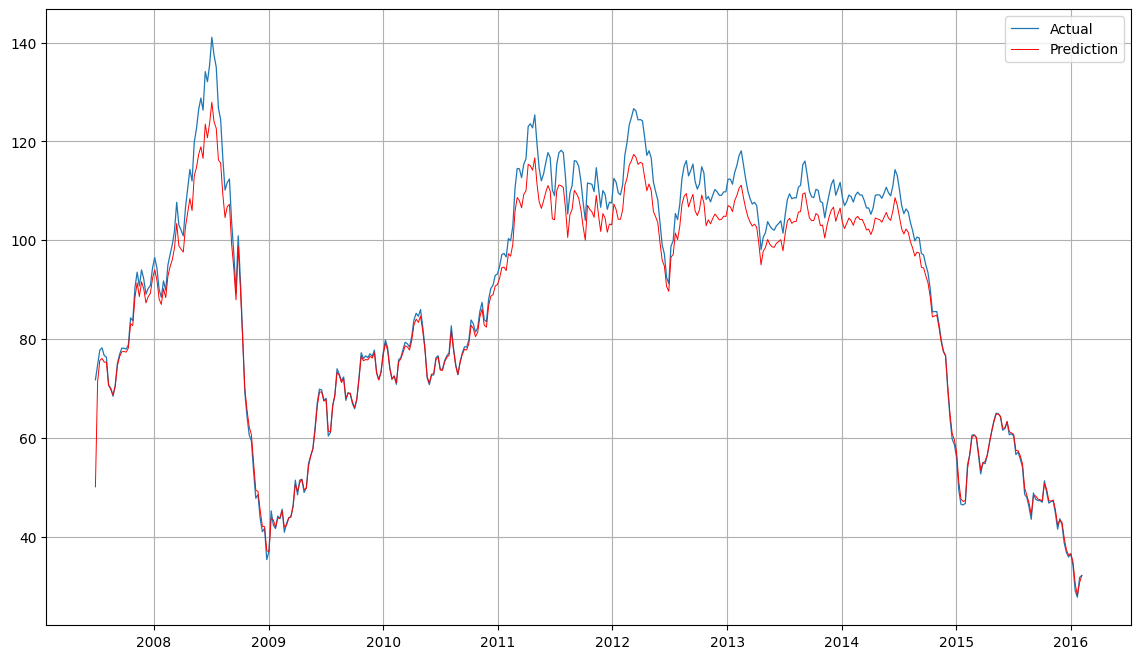

In [759]:
train_set_np = np.array(train_set)
results = scaler.inverse_transform(test_out)
plt.plot(elect_data[split_point:], linewidth=0.9)
results_df = pd.DataFrame(data = results, index=elect_data.index[split_point:])
plt.grid(True)
plt.plot(results_df, color="red", linewidth=0.7)
plt.legend(["Actual", "Prediction"])

##sliding window lstm


In [700]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        out, (hidden, cell) = self.lstm(input.view(len(input), 1))
        out = self.linear(out)
        
        return out[-1]

In [707]:
def slide(model, optimizer, sequence, lookback, horizon): 

  seq_len = len(sequence)
  results = [None] * (seq_len - lookback)
  for i in range(0, seq_len - lookback - horizon + 1):
    out = model(sequence[i:i+lookback])
    # print(sequence[i:i+lookback])
    loss = loss_fun(out, sequence[i+lookback: i+lookback+horizon])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    temp = out.detach().flatten().tolist()
    # print(temp)
    results[i: i+horizon] = [*temp]
  # out = model(sequence[0:lookback])
  # results[0:] = out
  # print(results)

  return results


In [715]:
lookback = 50
horizon = 10
model = LSTM(1, 15, 1, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.05)
loss_fun = nn.MSELoss()
epochs = 250

In [ ]:
results = []
for epoch in range(epochs): 
  # results = slide(model, optimizer, torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,11, 12, 13, 14, 15], dtype=torch.float32), lookback, horizon)
  results = slide(model, optimizer, train_set, lookback, horizon)
# print(list(map(lambda x: np.array(x), results)))
# results = [el for res in results for el in res

tensor(0.0266)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


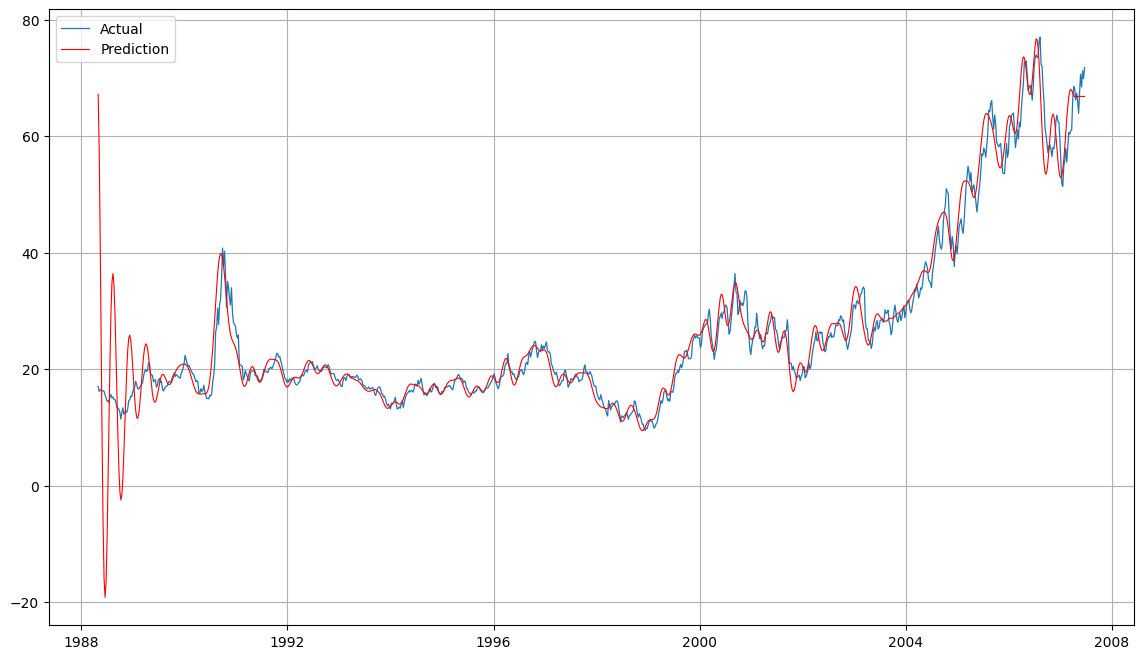

In [724]:
print(loss_fun(torch.tensor(results),train_set[lookback:]))
# print(len(elect_data.index[lookback:split_point]))
scaled_res = scaler.inverse_transform(np.array(results).reshape(-1, 1))
# print(scaled_res)
# print(np.array(results).reshape(-1, 1))
plt.plot(elect_data[lookback:split_point], linewidth=0.9)
results_df = pd.DataFrame(data = scaled_res, index=elect_data.index[lookback:split_point])
# # print(results_df)
plt.grid(True)
plt.plot(results_df, color="red", linewidth=0.8)
plt.legend(["Actual", "Prediction"])

In [738]:
slide_test_set = torch.cat((train_set[-lookback:], test_set))
slide_test_out = slide(model, optimizer, slide_test_set, lookback, horizon)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0758)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([450, 1])) that is different to the input size (torch.Size([450])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


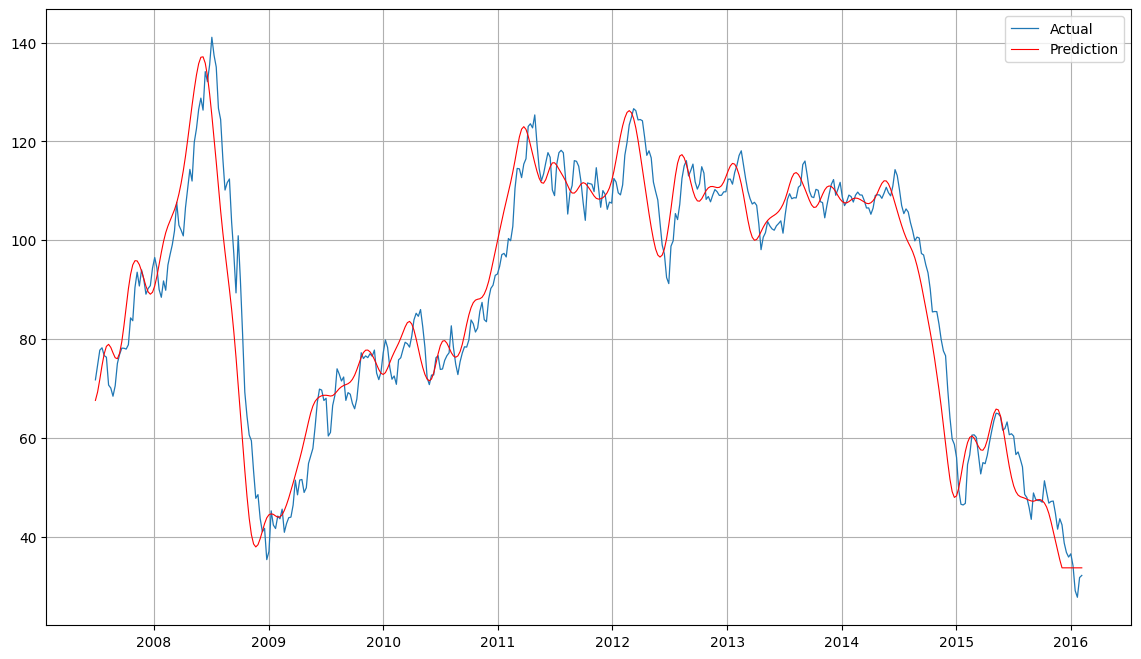

In [742]:
print(loss_fun(torch.tensor(slide_test_out),test_set))
scaled_res = scaler.inverse_transform(np.array(slide_test_out).reshape(-1, 1))
plt.plot(elect_data[split_point:], linewidth=0.9)
results_df = pd.DataFrame(data = scaled_res, index=elect_data.index[split_point:])
plt.grid(True)
plt.plot(results_df, color="red", linewidth=0.8)
plt.legend(["Actual", "Prediction"])

In [ ]:

# tn = torch.tensor([1, 2, 3], dtype=torch.float32)
# tn2 = torch.tensor([1, 1, 1], dtype=torch.float32)
# lin = nn.Linear(5, 2)
# lstm = nn.LSTM(1, 5, 1)
# out, _ = lstm(tn.view(3, 1))
# out2, _ = lstm(tn2.view(3, 1))
# print(out[1:])
# print(torch.cat((out, out2, torch.empty(0))))
# print()
# print(lin(out))

In [744]:
def slide2(model, optimizer, sequence, lookback, horizon): 

  seq_len = len(sequence)
  results = torch.empty(0)
  for i in range(0, seq_len - lookback - horizon + 1):
    out = model(sequence[i:i+lookback])
    # print(sequence[i:i+lookback])
    # loss = loss_fun(out, sequence[i+lookback: i+lookback+horizon])
    # loss.backward()
    # optimizer.step()
    # optimizer.zero_grad()
    # temp = out.detach().flatten().tolist()
    # print(temp)
    # results[i: i+horizon] = [*temp]
    results = torch.cat((results[:i], out))
  # out = model(sequence[0:lookback])
  # results[0:] = out
  # print(results)

  return results


In [745]:
lookback = 50
horizon = 10
model = LSTM(1, 15, 1, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.05)
loss_fun = nn.MSELoss()
epochs = 250

In [746]:
testing_torch = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,11, 12, 13, 14, 15], dtype=torch.float32)
results = []
for epoch in range(epochs): 
  # results = slide2(model, optimizer, testing_torch, lookback, horizon)
  results = slide2(model, optimizer, train_set, lookback, horizon)
  loss = loss_fun(results, train_set[lookback:])
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
# print(list(map(lambda x: np.array(x), results)))
# results = [el for res in results for el in res]
# print((results))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [747]:
results = results.detach().reshape(-1, 1).tolist()
results = scaler.inverse_transform(results)